In [1]:
import sys
sys.path.append("..") # this adds to path parent directory in order to import utils file

import numpy as np
import pandas as pd
from scipy import sparse, io
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from collections import Counter
from IPython.display import clear_output, Image, display
from collections import OrderedDict
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.manifold import MDS
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans, AffinityPropagation, DBSCAN, FeatureAgglomeration
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from IPython.display import clear_output, Image, display
import pickle
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import AffinityPropagation
import tqdm
from tqdm import tqdm
from sklearn import cluster, datasets, mixture
import scanpy.api as sc
import umap
plt.ion()
plt.show()

In [17]:
def getUmap(dataset, ncomp = 2):
    reducer = umap.UMAP(n_neighbors=50,
                          min_dist=0.1)
    embedding2d = reducer.fit_transform(dataset)
    plt.scatter(embedding2d[:, 0], embedding2d[:, 1], s = 4)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of celegans');
    plt.show()
    return embedding2d


def getTSNE(dataset, ncomp = 2, color = 'blue'):
    reducer = TSNE()
    embedding2d = reducer.fit_transform(dataset)
    plt.scatter(embedding2d[:, 0], embedding2d[:, 1], s = 4, c = color)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('TSNE projection of celegans');
    plt.show()
    return embedding2d

In [3]:
singleCellGenes = np.array(['gcy-3', 'nlp-6', 'gcy-8', 'tbh-1', 'ttr-39', 'ocr-3', 'nlp-19', 'Y75B8A.11', 'Y11D7A.8', 
                   'gcy-11', 'flp-17', 'Y57G11C.45', 'nlp-12', 'flp-11', 'C41A3.1', 'nlp-17', 'nlp-42' ])
alpha = 0.05

## Actual matrix for visualization
The scaling above transformed the dataframe into a matrix, losing info about the cell names and gene name.
We reconvert the matrix to dataframe and add lost information

In [4]:
# df_matrix = pd.read_pickle('../data/df.pkl')


In [5]:
df = pd.read_pickle('data/df.pkl')
columns = df.columns
cells = df.index.values
df = df.as_matrix()
/print df.shape


C:\Users\ciort\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


(7603, 12355)


## Data preprocessing

### Apply log to reduce distance between values

In [6]:
df = np.log1p(df)

## Calulcate gene variance

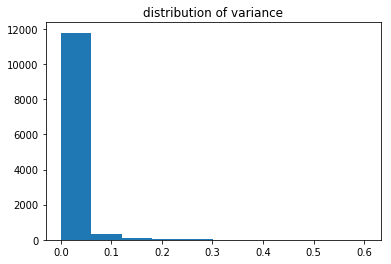

In [7]:
var = df.var(axis=0)
plt.title('distribution of variance')
plt.hist(var);

## Keep only genes with variance > 0.001

In [8]:
idx = np.where(var>0.001)[0]
print(f"Keeping {len(idx)} genes")

Keeping 8205 genes


In [9]:
df = df[:, idx]

### Normalize by cell

In [10]:
%%time
# df =  StandardScaler().fit_transform(df.T).T
# df =  StandardScaler().fit_transform(df)

df =  RobustScaler().fit_transform(df)

Wall time: 5.39 s


In [11]:
df = np.log1p(df)

## UMAP plot of original data - takes too long

In [12]:
# %%time
# reducer = umap.UMAP(n_neighbors=50,
#                       min_dist=0.1)
# embedding2d = reducer.fit_transform(df)
# print(embedding2d.shape)

# plt.scatter(embedding2d[:, 0], embedding2d[:, 1], s = 4)
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of celegans', fontsize=24);

## PCA decomposition

In [13]:
from sklearn.decomposition import PCA

In [14]:
pc = PCA(n_components=8).fit_transform(df) # works with 1000, doesn't work with 12000

Compute neighbors on PCA

In [15]:
from sklearn.neighbors import kneighbors_graph
import igraph as ig
import louvain

def cluster_knn_louvain(data, neighbors = 10):
    A = kneighbors_graph(pc, 10, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # this adds adjacency.shap[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)
    partition_type = louvain.RBConfigurationVertexPartition
    partition_kwargs = {}
    partition_kwargs["weights"] = weights
    part = louvain.find_partition(g, partition_type, **partition_kwargs)
    groups = np.array(part.membership)
    return groups

groups = cluster_knn_louvain(pc, neighbors = 10)
Counter(groups)

Counter({15: 226,
         1: 659,
         2: 561,
         0: 710,
         3: 557,
         14: 326,
         7: 420,
         19: 48,
         16: 182,
         11: 384,
         9: 399,
         13: 331,
         6: 426,
         18: 123,
         10: 384,
         5: 455,
         4: 474,
         17: 170,
         8: 406,
         12: 362})

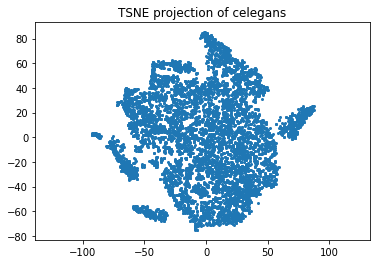

In [16]:
tsne2dPCA = getTSNE(pc)

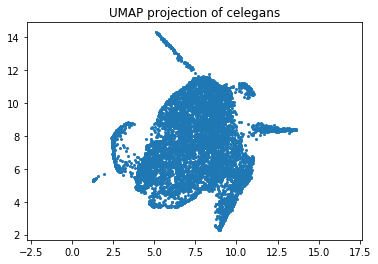

In [21]:
embedding2dPCA = getUmap(pc)

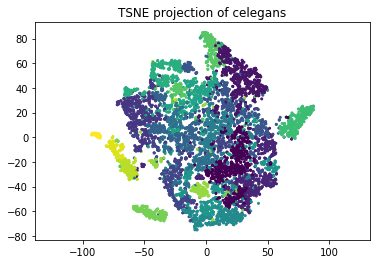

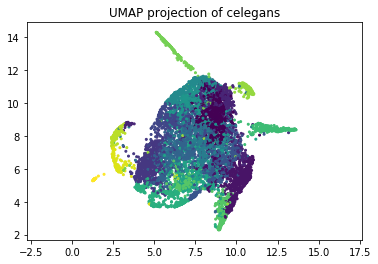

In [22]:
plt.scatter(tsne2dPCA[:, 0], tsne2dPCA[:, 1], s = 4, c = groups)
plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of celegans');
plt.figure()

plt.scatter(embedding2dPCA[:, 0], embedding2dPCA[:, 1], s = 4, c = groups)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of celegans');

## Debugging seurat

In [ ]:
n_neighbors = 10
knn = False
X = pc
use_dense_distances = False
method = 'umap'
metric = 'euclidean'
metric_kwds ={}
random_state = 0

In [ ]:
if use_dense_distances:
    _distances = pairwise_distances(X, metric=metric, **metric_kwds)
    knn_indices, knn_distances = get_indices_distances_from_dense_matrix(
        _distances, n_neighbors)
    if knn:
        self._distances = get_sparse_matrix_from_indices_distances_numpy(
            knn_indices, knn_distances, X.shape[0], n_neighbors)
    else:
        self._distances = _distances
else:
    # non-euclidean case and approx nearest neighbors
    if X.shape[0] < 4096:
        X = pairwise_distances(X, metric=metric, **metric_kwds)
        metric = 'precomputed'
    knn_indices, knn_distances = compute_neighbors_umap(
        X, n_neighbors, random_state, metric=metric, metric_kwds=metric_kwds)
#

In [ ]:
if not use_dense_distances or method == 'umap':
    # we need self._distances also for method == 'gauss' if we didn't
    # use dense distances
    distances, connectivities = compute_connectivities_umap(
        knn_indices, knn_distances, X.shape[0], n_neighbors)
    

In [ ]:
distances.shape, connectivities.shape

In [ ]:
# overwrite the umap connectivities if method is 'gauss'
# self._distances is unaffected by this
# if method == 'gauss':
#     self._compute_connectivities_diffmap()
# logg.msg('computed connectivities', t=True, v=4)
# self._number_connected_components = 1
# if issparse(self._connectivities):
#     from scipy.sparse.csgraph import connected_components
#     self._connected_components = connected_components(self._connectivities)
#     self._number_connected_components = self._connected_components[0]

In [ ]:
import igraph as ig
sources, targets = connectivities.nonzero()

In [ ]:
weights = connectivities[sources, targets]
if isinstance(weights, np.matrix):
    print('--')
    weights = weights.A1
    

In [ ]:
directed = False
g = ig.Graph(directed=directed)
g.add_vertices(connectivities.shape[0])  # this adds adjacency.shap[0] vertices
g.add_edges(list(zip(sources, targets)))

g.es['weight'] = weights

In [ ]:
weights = np.array(g.es["weight"]).astype(np.float64)

In [ ]:
import louvain
partition_type = louvain.RBConfigurationVertexPartition
partition_kwargs = {}
partition_kwargs["weights"] = weights

In [ ]:
part = louvain.find_partition(g, partition_type, **partition_kwargs)
groups = np.array(part.membership)

In [ ]:
np.unique(groups)

In [ ]:
from scipy.sparse import issparse, coo_matrix

def compute_neighbors_umap(
        X, n_neighbors, random_state=None,
        metric='euclidean', metric_kwds={}, angular=False,
        verbose=False):
    from scanpy.neighbors.umap import sparse
    from scanpy.neighbors.umap.umap_ import rptree_leaf_array, make_nn_descent
    from scanpy.neighbors.umap import distances as dist
    from scanpy.neighbors.umap import sparse
    import scipy
    from sklearn.utils import check_random_state

    INT32_MIN = np.iinfo(np.int32).min + 1
    INT32_MAX = np.iinfo(np.int32).max - 1

    random_state = check_random_state(random_state)

    if metric == 'precomputed':
        # Note that this does not support sparse distance matrices yet ...
        # Compute indices of n nearest neighbors
        knn_indices = np.argsort(X)[:, :n_neighbors]
        # Compute the nearest neighbor distances
        #   (equivalent to np.sort(X)[:, :n_neighbors])
        knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
    else:
        if callable(metric):
            distance_func = metric
        elif metric in dist.named_distances:
            distance_func = dist.named_distances[metric]
        else:
            raise ValueError('Metric is neither callable, ' +
                             'nor a recognised string')

        if metric in ('cosine', 'correlation', 'dice', 'jaccard'):
            angular = True

        rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

        if scipy.sparse.isspmatrix_csr(X):
            if metric in sparse.sparse_named_distances:
                distance_func = sparse.sparse_named_distances[metric]
                if metric in sparse.sparse_need_n_features:
                    metric_kwds['n_features'] = X.shape[1]
            else:
                raise ValueError('Metric {} not supported for sparse ' +
                                'data'.format(metric))
            metric_nn_descent = sparse.make_sparse_nn_descent(
                distance_func, tuple(metric_kwds.values()))
            leaf_array = rptree_leaf_array(X, n_neighbors,
                                           rng_state, n_trees=10,
                                           angular=angular)
            knn_indices, knn_dists = metric_nn_descent(X.indices,
                                                       X.indptr,
                                                       X.data,
                                                       X.shape[0],
                                                       n_neighbors,
                                                       rng_state,
                                                       max_candidates=60,
                                                       rp_tree_init=True,
                                                       leaf_array=leaf_array,
                                                       verbose=verbose)
        else:
            metric_nn_descent = make_nn_descent(distance_func,
                                                tuple(metric_kwds.values()))
            # TODO: Hacked values for now
            n_trees = 5 + int(round((X.shape[0]) ** 0.5 / 20.0))
            n_iters = max(5, int(round(np.log2(X.shape[0]))))

            leaf_array = rptree_leaf_array(X, n_neighbors,
                                           rng_state, n_trees=n_trees,
                                           angular=angular)
            knn_indices, knn_dists = metric_nn_descent(X,
                                                       n_neighbors,
                                                       rng_state,
                                                       max_candidates=60,
                                                       rp_tree_init=True,
                                                       leaf_array=leaf_array,
                                                       n_iters=n_iters,
                                                       verbose=verbose)

        if np.any(knn_indices < 0):
            logg.warn('Failed to correctly find n_neighbors for some samples. '
                 'Results may be less than ideal. Try re-running with '
                 'different parameters.')

    return knn_indices, knn_dists


def compute_connectivities_umap(knn_indices, knn_dists,
        n_obs, n_neighbors, set_op_mix_ratio=1.0,
        local_connectivity=1.0, bandwidth=1.0):
    """This is from umap.fuzzy_simplicial_set [McInnes18]_.

    Given a set of data X, a neighborhood size, and a measure of distance
    compute the fuzzy simplicial set (here represented as a fuzzy graph in
    the form of a sparse matrix) associated to the data. This is done by
    locally approximating geodesic distance at each point, creating a fuzzy
    simplicial set for each such point, and then combining all the local
    fuzzy simplicial sets into a global one via a fuzzy union.
    """
    from scanpy.neighbors.umap.umap_ import smooth_knn_dist

    rows = np.zeros((n_obs * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_obs * n_neighbors), dtype=np.int64)
    sims = np.zeros((n_obs * n_neighbors), dtype=np.float64)
    dists = np.zeros((n_obs * n_neighbors), dtype=np.float64)

    sigmas, rhos = smooth_knn_dist(knn_dists, n_neighbors,
                                   local_connectivity=local_connectivity)

    for i in range(knn_indices.shape[0]):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                sim = 0.0
                dist = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                sim = 1.0
                dist = knn_dists[i, j]
            else:
                sim = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i] *
                                                              bandwidth)))
                dist = knn_dists[i, j]

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            sims[i * n_neighbors + j] = sim
            dists[i * n_neighbors + j] = dist

    connectivities = coo_matrix((sims, (rows, cols)),
                               shape=(n_obs, n_obs))
    connectivities.eliminate_zeros()

    distances = coo_matrix((dists, (rows, cols)),
                           shape=(n_obs, n_obs))
    distances.eliminate_zeros()

    transpose = connectivities.transpose()

    prod_matrix = connectivities.multiply(transpose)

    connectivities = set_op_mix_ratio * (connectivities + transpose - prod_matrix) + \
             (1.0 - set_op_mix_ratio) * prod_matrix

    connectivities.eliminate_zeros()
    return distances.tocsr(), connectivities.tocsr()


In [ ]:
embedding2dPCA = getUmap(pc)

In [ ]:
tsne2dPCA = getTSNE(pc)

In [ ]:
# r_pca = bestGMM(pc)